(589, 1452)


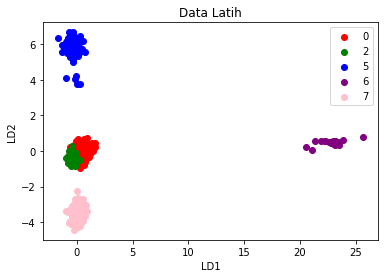

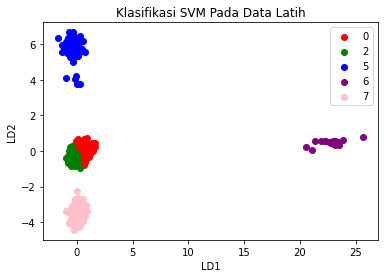

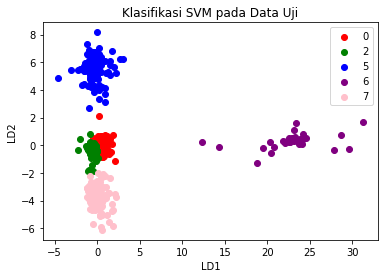

[[180  16   0   0   0]
 [  7 180   0   0   0]
 [  1   0 209   0   0]
 [  0   0   0 186   0]
 [  2   5   0   0 182]]
accuracy = 0.9679752066115702
(589, 1452)


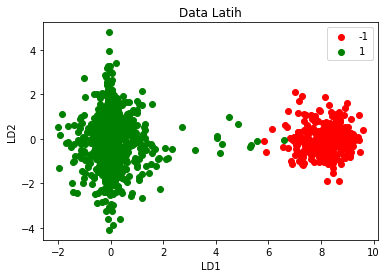

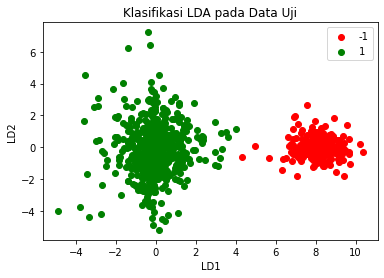

[[196   0]
 [  5 767]]
accuracy = 0.9948347107438017


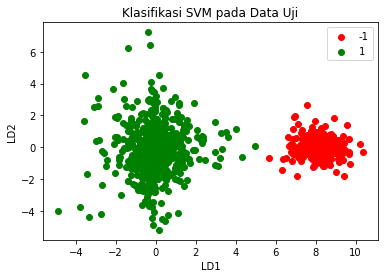

[[196   0]
 [  3 769]]
accuracy = 0.996900826446281


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from libsvm.svmutil import *
# import training dataset
datset = pd.read_csv("../Data Pengujian/DatasetRzOther.csv",header=None,skiprows=0, delimiter=';')
datset = datset.iloc[:,:53]
x= datset.iloc[:,:-1]
L= datset.iloc[:,-1]

from sklearn.model_selection import train_test_split
x, X_test, L, L_test = train_test_split(x, L, test_size= .4, random_state=40)

gamma = 0.00005
xtrain = x
from sklearn.metrics.pairwise import rbf_kernel
K = rbf_kernel(xtrain, gamma = gamma)
K = pd.DataFrame.from_records(K)
#### Centering Kernel Matrix
m = np.shape(xtrain)[0]
seper_m = np.ones((m,m))/m
Kc = K - seper_m.dot(K) - K.dot(seper_m) + seper_m.dot(K).dot(seper_m)
#### KPCA
eigenValues, eigenVectors = np.linalg.eig(Kc)
eigenValues = np.real(eigenValues)
eigenVectors = np.real(eigenVectors)
idx = eigenValues.argsort()[::-1] #Outputs idx for sorting eigenValues and ordering by descending value
eigenValues = eigenValues[idx] #sorting eigenValues by idx
eigenVectors = np.real(eigenVectors[:,idx]) #sorting eigenVectors by idx
#slicing the eigens
eigenValues = eigenValues[:589]
eigenVectors = eigenVectors[:,:589]
kpcamat = []
for i in range(len(eigenValues)):
    if (eigenValues[i] < 1e-15):
        end_index = i
        print("index:", i, "value:",eigenValues[i])
        break
    scaled_eigenvector = eigenVectors[:,i]/(np.sqrt(eigenValues[i]))
    kpcamat.append(scaled_eigenvector)
kpcamat = np.array(kpcamat)
print(np.shape(kpcamat))
kpcamat = kpcamat.T
#### Transforming Kernel Matrix into KPCA-space
xtrainkpca = kpcamat.T.dot(K)
xtrainkpca = pd.DataFrame.from_records(xtrainkpca)
### FDA
classes = np.unique(L)
k = len(classes)
M = xtrainkpca.mean(axis = 1)
try:
    st = np.diagflat(eigenValues[:end_index]) #Total variance
except NameError:
    st = np.diagflat(eigenValues[:]) #Total variance
#### Looping to find sb
sb=0 #initial value
yt = xtrainkpca.T
yt = pd.DataFrame.from_records(yt)
for j in range(k):
    a = 0
    a = np.where(L == classes[j])[0]
    Kj = pd.DataFrame()
    an = len(a)
    for ak in range(an):
        ai = a[ak]
        k2add = xtrainkpca.iloc[:,ai]
        Kj[ak] = k2add
    nj = Kj.shape[1]
    Kj = Kj.to_numpy()
    mj = Kj.mean(axis = 1)
    sb = sb + nj*np.outer((mj-M),(mj-M)) #Variance between class

sb = sb/m #Scaling sb
st_i = np.linalg.inv(st)
eigenValues1, eigenVectors1 = np.linalg.eig(st_i.dot(sb))
eigenValues1 = np.real(eigenValues1)
eigenVectors1 = np.real(eigenVectors1)
idx1 = eigenValues1.argsort()[::-1] #Outputs idx for sorting eigenValues and ordering by descending value
eigenValues1 = eigenValues1[idx1] #sorting eigenValues by idx
eigenVectors1 = np.real(eigenVectors1[:,idx1]) #sorting eigenVectors by idx
kfdamat = eigenVectors1[:,:2] / np.sqrt(eigenValues1[:2]) #KFDA Transformation Matrix
#### Transforming KFDA Matrix into KFDA matrix
xtrainkfda = kfdamat.T.dot(xtrainkpca)
xtrainkfda = xtrainkfda.T

from sklearn.preprocessing import RobustScaler
sc = RobustScaler()
xtrainkfda = sc.fit_transform(xtrainkfda)

from sklearn import svm
clf= svm.SVC()
clf = clf.fit(xtrainkfda ,L)
c = ['red', 'green', 'blue', 'purple', 'pink']

#Train
X_settr, y_settr = xtrainkfda, L
for i, j in enumerate(np.unique(y_settr)):
    plt.scatter(X_settr[y_settr == j, 0], X_settr[y_settr == j, 1],
                c = c[i], label = j)
plt.title('Data Latih')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend()
plt.show()

y_pred = clf.predict(xtrainkfda)
X_settr, y_settr = xtrainkfda, y_pred
for i, j in enumerate(np.unique(y_settr)):
    plt.scatter(X_settr[y_settr == j, 0], X_settr[y_settr == j, 1],
                    c = c[i], label = j)
plt.title('Klasifikasi SVM Pada Data Latih')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend()
plt.show()

#test
K_test = rbf_kernel(xtrain, X_test, gamma = gamma)
y_test = kpcamat.T.dot(K_test)
y1_test = kfdamat.T.dot(y_test)
y1_test = y1_test.T
y1_test = sc.transform(y1_test)
y1_test_pred = clf.predict(y1_test)

X_setts,y_setts=y1_test,y1_test_pred
for i, j in enumerate(np.unique(y_setts)):
    plt.scatter(X_setts[y_setts == j, 0], X_setts[y_setts == j, 1],
                c = c[i],label = j)
plt.title('Klasifikasi SVM pada Data Uji')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend()
plt.show()
from sklearn.metrics import confusion_matrix, accuracy_score
cm=confusion_matrix(L_test,y1_test_pred)
print(cm)
print('accuracy = '+str(accuracy_score(L_test,y1_test_pred)))

#test 2 class
L2 = [-1 if l == 0 else 1 for l in L]
L_test2 = [-1 if l == 0 else 1 for l in L_test]

K = rbf_kernel(xtrain, gamma = gamma)
K = pd.DataFrame.from_records(K)
#### Centering Kernel Matrix
m = np.shape(xtrain)[0]
seper_m = np.ones((m,m))/m
Kc = K - seper_m.dot(K) - K.dot(seper_m) + seper_m.dot(K).dot(seper_m)
#### KPCA
eigenValues, eigenVectors = np.linalg.eig(Kc)
eigenValues = np.real(eigenValues)
eigenVectors = np.real(eigenVectors)
idx = eigenValues.argsort()[::-1] #Outputs idx for sorting eigenValues and ordering by descending value
eigenValues = eigenValues[idx] #sorting eigenValues by idx
eigenVectors = np.real(eigenVectors[:,idx]) #sorting eigenVectors by idx
#slicing the eigens
eigenValues = eigenValues[:589]
eigenVectors = eigenVectors[:,:589]
kpcamat = []
for i in range(len(eigenValues)):
    if (eigenValues[i] < 1e-15):
        end_index = i
        print("index:", i, "value:",eigenValues[i])
        break
    scaled_eigenvector = eigenVectors[:,i]/(np.sqrt(eigenValues[i]))
    kpcamat.append(scaled_eigenvector)
kpcamat = np.array(kpcamat)
print(np.shape(kpcamat))
kpcamat = kpcamat.T
#### Transforming Kernel Matrix into KPCA-space
xtrainkpca = kpcamat.T.dot(K)
xtrainkpca = pd.DataFrame.from_records(xtrainkpca)
### FDA
classes = np.unique(L2)
k = len(classes)
M = xtrainkpca.mean(axis = 1)
try:
    st = np.diagflat(eigenValues[:end_index]) #Total variance
except NameError:
    st = np.diagflat(eigenValues[:]) #Total variance
#### Looping to find sb
sb=0 #initial value
yt = xtrainkpca.T
yt = pd.DataFrame.from_records(yt)
for j in range(k):
    a = 0
    a = np.where(L2 == classes[j])[0]
    Kj = pd.DataFrame()
    an = len(a)
    for ak in range(an):
        ai = a[ak]
        k2add = xtrainkpca.iloc[:,ai]
        Kj[ak] = k2add
    nj = Kj.shape[1]
    Kj = Kj.to_numpy()
    mj = Kj.mean(axis = 1)
    sb = sb + nj*np.outer((mj-M),(mj-M)) #Variance between class

sb = sb/m #Scaling sb
st_i = np.linalg.inv(st)
eigenValues1, eigenVectors1 = np.linalg.eig(st_i.dot(sb))
eigenValues1 = np.real(eigenValues1)
eigenVectors1 = np.real(eigenVectors1)
idx1 = eigenValues1.argsort()[::-1] #Outputs idx for sorting eigenValues and ordering by descending value
eigenValues1 = eigenValues1[idx1] #sorting eigenValues by idx
eigenVectors1 = np.real(eigenVectors1[:,idx1]) #sorting eigenVectors by idx
kfdamat = eigenVectors1[:,:2] / np.sqrt(eigenValues1[:2]) #KFDA Transformation Matrix
#### Transforming KFDA Matrix into KFDA matrix
xtrainkfda = kfdamat.T.dot(xtrainkpca)
xtrainkfda = xtrainkfda.T

sc = RobustScaler()
xtrainkfda = sc.fit_transform(xtrainkfda)

#Train
X_settr, y_settr = xtrainkfda, L2
for i, j in enumerate(np.unique(y_settr)):
    plt.scatter(X_settr[y_settr == j, 0], X_settr[y_settr == j, 1],
                c = c[i], label = j)
plt.title('Data Latih')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend()
plt.show()

# y_pred = clf.predict(xtrainkfda)
# X_settr, y_settr = xtrainkfda, y_pred
# for i, j in enumerate(np.unique(y_settr)):
#     plt.scatter(X_settr[y_settr == j, 0], X_settr[y_settr == j, 1],
#                     c = c[i], label = j)
# plt.title('SVM Classification of Training Set')
# plt.xlabel('LD1')
# plt.ylabel('LD2')
# plt.legend()
# plt.show()

#test
K_test = rbf_kernel(xtrain, X_test, gamma = gamma)
y_test = kpcamat.T.dot(K_test)
y1_test = kfdamat.T.dot(y_test)
y1_test = y1_test.T
y1_test = sc.transform(y1_test)

from sklearn import discriminant_analysis
clf2 = discriminant_analysis.LinearDiscriminantAnalysis()
clf2 = clf2.fit(xtrainkfda ,L2)
c = ['red', 'green']
y1_test_pred2 = clf2.predict(y1_test)

X_setts,y_setts=y1_test,y1_test_pred2
for i, j in enumerate(np.unique(y_setts)):
    plt.scatter(X_setts[y_setts == j, 0], X_setts[y_setts == j, 1],
                c = c[i],label = j)
plt.title('Klasifikasi LDA pada Data Uji')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend()
plt.show()

cm2=confusion_matrix(L_test2,y1_test_pred2)
print(cm2)
print('accuracy = '+str(accuracy_score(L_test2,y1_test_pred2)))

clf2 = svm.LinearSVC()
clf2 = clf2.fit(xtrainkfda ,L2)
c = ['red', 'green']
y1_test_pred2 = clf2.predict(y1_test)

X_setts,y_setts=y1_test,y1_test_pred2
for i, j in enumerate(np.unique(y_setts)):
    plt.scatter(X_setts[y_setts == j, 0], X_setts[y_setts == j, 1],
                c = c[i],label = j)
plt.title('Klasifikasi SVM pada Data Uji')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend()
plt.show()

cm2=confusion_matrix(L_test2,y1_test_pred2)
print(cm2)
print('accuracy = '+str(accuracy_score(L_test2,y1_test_pred2)))


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# import training dataset
datafolder = Path('../Dataset/Data Skripsi 1')
datafile = datafolder/ 'DatasetRz.xlsx'
dataset = pd.read_excel(datafile, header = None, sheet_name='Sheet1')
xtrain= dataset.iloc[0:200,:-2]
Ltrain= dataset.iloc[0:200,-1]
m = np.shape(xtrain)[0]

#KFDA = KPCA + LDA
#KPCA
from sklearn.metrics.pairwise import rbf_kernel

list_gamma= [0.0085, 0.02, 0.05, 0.1, 0.2]
index=[500, 660, 820, 980, 1140, 1300, 1460, 1620, 1780, 1940, 2100, 2260]
num_trial=3
buffer_size_input_list=[50, 100, 150, 200]
0
df=[]
for bufs in range(len(buffer_size_input_list)):
    buffer_size_input=buffer_size_input_list[bufs]
    if buffer_size_input < 160:
        pocket_size = 160
    elif buffer_size_input > 160:
        pocket_size = buffer_size_input

    for gams in range(len(list_gamma)):
        gamma = list_gamma[gams]
        K = rbf_kernel(xtrain, gamma = gamma)
        K = pd.DataFrame.from_records(K)
        #### Centering Kernel Matrix
        m = np.shape(xtrain)[0]
        seper_m = np.ones((m,m))/m
        Kc = K - seper_m.dot(K) - K.dot(seper_m) + seper_m.dot(K).dot(seper_m)
        #### KPCA
        eigenValues, eigenVectors = np.linalg.eig(Kc)
        eigenValues = np.real(eigenValues)
        eigenVectors = np.real(eigenVectors)
        idx = eigenValues.argsort()[::-1] #Outputs idx for sorting eigenValues and ordering by descending value
        eigenValues = eigenValues[idx] #sorting eigenValues by idx
        eigenVectors = np.real(eigenVectors[:,idx]) #sorting eigenVectors by idx
        #slicing the eigens
        eigenValues = eigenValues[:589]
        eigenVectors = eigenVectors[:,:589]
        kpcamat = []
        end_index = 0
        for i in range(len(eigenValues)):
            if (eigenValues[i] < 1e-15):
                end_index = i
                print("index:", i, "value:",eigenValues[i])
                break
            scaled_eigenvector = eigenVectors[:,i]/(np.sqrt(eigenValues[i]))
            kpcamat.append(scaled_eigenvector)
        kpcamat = np.array(kpcamat)
        print(np.shape(kpcamat))
        kpcamat = kpcamat.T
        #### Transforming Kernel Matrix into KPCA-space
        xtrainkpca = kpcamat.T.dot(K)
        xtrainkpca = pd.DataFrame.from_records(xtrainkpca)
        ### FDA
        classes = np.unique(Ltrain)
        k = len(classes)
        M = xtrainkpca.mean(axis = 1)
        if end_index == 0:
            st = np.diagflat(eigenValues[:]) #Total variance
        else:
            st = np.diagflat(eigenValues[:end_index]) #Total variance
        #### Looping to find sb
        sb=0 #initial value
        yt = xtrainkpca.T
        yt = pd.DataFrame.from_records(yt)
        for j in range(k):
            a = 0
            a = np.where(Ltrain == classes[j])[0]
            Kj = pd.DataFrame()
            an = len(a)
            for ak in range(an):
                ai = a[ak]
                k2add = xtrainkpca.iloc[:,ai]
                Kj[ak] = k2add
            nj = Kj.shape[1]
            Kj = Kj.to_numpy()
            mj = Kj.mean(axis = 1)
            sb = sb + nj*np.outer((mj-M),(mj-M)) #Variance between class

        sb = sb/m #Scaling sb
        st_i = np.linalg.inv(st)
        eigenValues1, eigenVectors1 = np.linalg.eig(st_i.dot(sb))
        eigenValues1 = np.real(eigenValues1)
        eigenVectors1 = np.real(eigenVectors1)
        idx1 = eigenValues1.argsort()[::-1] #Outputs idx for sorting eigenValues and ordering by descending value
        eigenValues1 = eigenValues1[idx1] #sorting eigenValues by idx
        eigenVectors1 = np.real(eigenVectors1[:,idx1]) #sorting eigenVectors by idx
        kfdamat = eigenVectors1[:,:2] / np.sqrt(eigenValues1[:2]) #KFDA Transformation Matrix
        #### Transforming KFDA Matrix into KFDA matrix
        xtrainkfda = kfdamat.T.dot(xtrainkpca)
        xtrainkfda = xtrainkfda.T

        from sklearn.preprocessing import RobustScaler
        rs = RobustScaler()
        xtrainkfda = rs.fit_transform(xtrainkfda)
        # Testing Set
        print(buffer_size_input, gamma)
        for ix in range(len(index)):
            accuracy_list=[]
            print(index[ix],index[ix]+pocket_size)
            xtake= dataset.iloc[index[ix]:index[ix]+pocket_size,:-2]
            Ltake= dataset.iloc[index[ix]:index[ix]+pocket_size,-1]
            for i in range(1, num_trial+1):
                xtest = []
                Ltest = []
                if pocket_size != 200:
                    idx = np.random.choice(np.arange(index[ix],index[ix]+160), buffer_size_input, replace=False)
                    xtest = xtake[xtake.index.isin(idx)]
                    Ltest = Ltake[idx]
                elif pocket_size == 200 and index[ix] == 820 or index[ix] == 1300 or index[ix] == 1780:
                    xtest = xtake.iloc[:-40,:]
                    Ltest = Ltake[:-40]
                    idx = np.random.choice(np.arange(index[ix],index[ix]+160), 40, replace=False)
                    xtest = np.concatenate((xtest, xtake[xtake.index.isin(idx)]), axis=0)
                    Ltest = np.concatenate((Ltest, Ltake[idx]), axis=0)
                elif pocket_size == 200 and index[ix] == 2260:
                    idx = np.random.choice(np.arange(index[ix],index[ix]+160), 40, replace=False)
                    xtest = np.concatenate((xtake, xtake[xtake.index.isin(idx)]), axis=0)
                    Ltest = np.concatenate((Ltake, Ltake[idx]), axis=0)
                elif pocket_size == 200:
                    idx = np.random.choice(np.arange(index[ix],index[ix]+200), buffer_size_input, replace=False)
                    xtest = xtake[xtake.index.isin(idx)]
                    Ltest = Ltake[idx]
                K = rbf_kernel(xtrain, xtest, gamma = gamma)

                xtestkpca = kpcamat.T.dot(K)
                xtestkpca = pd.DataFrame.from_records(xtestkpca)

                xtestkfda = kfdamat.T.dot(xtestkpca)
                xtestkfda = xtestkfda.T
                xtestkfda = rs.transform(xtestkfda)
                #Joining Xtrain and Xtest
                Xkfda = np.concatenate((xtrainkfda, xtestkfda), axis=0)
                Ljoin = np.concatenate((Ltrain, Ltest), axis=0)

                #SVM
                from sklearn import svm
                clf= svm.SVC()
                #from sklearn import discriminant_analysis as lda
                #clf= lda.LinearDiscriminantAnalysis()
                clf = clf.fit(Xkfda,Ljoin)
                y_pred = clf.predict(Xkfda)

                from sklearn.metrics import accuracy_score                
                accuracy_list.append(accuracy_score(Ljoin,y_pred))
            print(index[ix], accuracy_list)
            df_entry = [buffer_size_input_list[bufs], gamma, index[ix], accuracy_list[0], accuracy_list[1], accuracy_list[2]]
            df.append(df_entry)
df = pd.DataFrame.from_records(df)
df.to_excel("pengujianoneclass200barulagi.xlsx")

(200, 200)
50 0.0085
500 660
500 [0.996, 0.992, 1.0]
660 820
660 [1.0, 1.0, 1.0]
820 980
820 [1.0, 1.0, 1.0]
980 1140
980 [0.992, 0.992, 0.992]
1140 1300
1140 [0.896, 0.928, 0.912]
1300 1460
1300 [0.952, 0.952, 0.956]
1460 1620
1460 [1.0, 1.0, 1.0]
1620 1780
1620 [1.0, 1.0, 1.0]
1780 1940
1780 [1.0, 1.0, 1.0]
1940 2100
1940 [1.0, 1.0, 1.0]
2100 2260
2100 [1.0, 1.0, 1.0]
2260 2420
2260 [1.0, 1.0, 1.0]
index: 199 value: 4.4372561368607023e-16
(199, 200)
50 0.02
500 660
500 [0.892, 0.892, 0.892]
660 820
660 [0.892, 0.892, 0.892]
820 980
820 [0.892, 0.892, 0.892]
980 1140
980 [0.892, 0.892, 0.892]
1140 1300
1140 [0.924, 0.908, 0.928]
1300 1460
1300 [0.892, 0.892, 0.892]
1460 1620
1460 [0.892, 0.892, 0.892]
1620 1780
1620 [0.892, 0.892, 0.892]
1780 1940
1780 [0.892, 0.892, 0.892]
1940 2100
1940 [0.892, 0.892, 0.892]
2100 2260
2100 [0.892, 0.892, 0.892]
2260 2420
2260 [0.892, 0.892, 0.892]
index: 199 value: 2.3906052925386413e-17
(199, 200)
50 0.05
500 660
500 [0.904, 0.904, 0.904]
660 820
6

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# import training dataset
datafolder = Path('../Dataset/Data Skripsi 1')
datafile = datafolder/ 'DatasetRz.xlsx'
dataset = pd.read_excel(datafile, header = None, sheet_name='Sheet1')

#Parameters
list_gamma = [0.0001, 0.00005, 0.00001, 0.000005, 0.000001]
list_ref = [50, 100, 150, 200]
buffs = 50
list_data_fault = [5, 10, 15, 20]
df=[]
for faults in list_data_fault:
    for gs in list_gamma:
        gamma = gs
        for refs in list_ref:
            xtrain= dataset.iloc[0:refs,:-2]
            Ltrain= dataset.iloc[0:refs,-1]
            stop_idx = 500-faults
            start_idx = stop_idx-buffs+faults
            print("index from", start_idx, "to", stop_idx)
            x1= dataset.iloc[start_idx:stop_idx,:-2]
            l1= dataset.iloc[start_idx:stop_idx,-1]
            x2= dataset.iloc[530:530+faults,:-2]
            l2= dataset.iloc[530:530+faults,-1]
            xtest = np.concatenate((x1, x2), axis=0)
            Ltest = np.concatenate((l1, l2), axis=0)

            #KFDA = KPCA + LDA
            #KPCA
            from sklearn.metrics.pairwise import rbf_kernel

            K = rbf_kernel(xtrain, gamma = gamma)
            K = pd.DataFrame.from_records(K)
            #### Centering Kernel Matrix
            m = np.shape(xtrain)[0]
            seper_m = np.ones((m,m))/m
            Kc = K - seper_m.dot(K) - K.dot(seper_m) + seper_m.dot(K).dot(seper_m)
            #### KPCA
            eigenValues, eigenVectors = np.linalg.eig(Kc)
            eigenValues = np.real(eigenValues)
            eigenVectors = np.real(eigenVectors)
            idx = eigenValues.argsort()[::-1] #Outputs idx for sorting eigenValues and ordering by descending value
            eigenValues = eigenValues[idx] #sorting eigenValues by idx
            eigenVectors = np.real(eigenVectors[:,idx]) #sorting eigenVectors by idx
            #slicing the eigens
            eigenValues = eigenValues[:589]
            eigenVectors = eigenVectors[:,:589]
            kpcamat = []
            end_index = 0
            for i in range(len(eigenValues)):
                if (eigenValues[i] < 1e-15):
                    end_index = i
                    #print("index:", i, "value:",eigenValues[i])
                    break
                scaled_eigenvector = eigenVectors[:,i]/(np.sqrt(eigenValues[i]))
                kpcamat.append(scaled_eigenvector)
            kpcamat = np.array(kpcamat)
            #print(np.shape(kpcamat))
            kpcamat = kpcamat.T
            #### Transforming Kernel Matrix into KPCA-space
            xtrainkpca = kpcamat.T.dot(K)
            xtrainkpca = pd.DataFrame.from_records(xtrainkpca)
            ### FDA
            classes = np.unique(Ltrain)
            k = len(classes)
            M = xtrainkpca.mean(axis = 1)
            if end_index == 0:
                st = np.diagflat(eigenValues[:]) #Total variance
            else:
                st = np.diagflat(eigenValues[:end_index]) #Total variance
            #### Looping to find sb
            sb=0 #initial value
            yt = xtrainkpca.T
            yt = pd.DataFrame.from_records(yt)
            for j in range(k):
                a = 0
                a = np.where(Ltrain == classes[j])[0]
                Kj = pd.DataFrame()
                an = len(a)
                for ak in range(an):
                    ai = a[ak]
                    k2add = xtrainkpca.iloc[:,ai]
                    Kj[ak] = k2add
                nj = Kj.shape[1]
                Kj = Kj.to_numpy()
                mj = Kj.mean(axis = 1)
                sb = sb + nj*np.outer((mj-M),(mj-M)) #Variance between class

            sb = sb/m #Scaling sb
            st_i = np.linalg.inv(st)
            eigenValues1, eigenVectors1 = np.linalg.eig(st_i.dot(sb))
            eigenValues1 = np.real(eigenValues1)
            eigenVectors1 = np.real(eigenVectors1)
            idx1 = eigenValues1.argsort()[::-1] #Outputs idx for sorting eigenValues and ordering by descending value
            eigenValues1 = eigenValues1[idx1] #sorting eigenValues by idx
            eigenVectors1 = np.real(eigenVectors1[:,idx1]) #sorting eigenVectors by idx
            kfdamat = eigenVectors1[:,:2] / np.sqrt(eigenValues1[:2]) #KFDA Transformation Matrix
            #### Transforming KFDA Matrix into KFDA matrix
            xtrainkfda = kfdamat.T.dot(xtrainkpca)
            xtrainkfda = xtrainkfda.T

            from sklearn.preprocessing import RobustScaler
            rs = RobustScaler()
            xtrainkfda = rs.fit_transform(xtrainkfda)

            # Testing Set

            K = rbf_kernel(xtrain, xtest, gamma = gamma)

            xtestkpca = kpcamat.T.dot(K)
            xtestkpca = pd.DataFrame.from_records(xtestkpca)

            xtestkfda = kfdamat.T.dot(xtestkpca)
            xtestkfda = xtestkfda.T
            xtestkfda = rs.transform(xtestkfda)

            c = ['red','blue']
            #Joining Xtrain and Xtest
            Xkfda = np.concatenate((xtrainkfda, xtestkfda), axis=0)
            Ljoin = np.concatenate((Ltrain, Ltest), axis=0)
            for Ls in range(len(Ljoin)):
                if Ljoin[Ls] == 1:
                    Ljoin[Ls] = 0
                else:
                    Ljoin[Ls] = 1
            sumall = len(Xkfda)

            # plt.scatter(xtrainkfda[Ltrain == 1, 0], xtrainkfda[Ltrain == 1, 1], s = 30, c = 'purple', label = 'Reference')
            # plt.scatter(xtestkfda[Ltest == 1, 0], xtestkfda[Ltest == 1, 1], s = 30, c = 'red', label = 'Normal')
            # plt.scatter(xtestkfda[Ltest == 2, 0], xtestkfda[Ltest == 2, 1], s = 30, c = 'blue', label = 'Faulty')
            # plt.title('Train + Test Set')
            # # plt.xlim([-.1, .1])
            # # plt.ylim([0, .2])
            # plt.xlabel('LD1')
            # plt.ylabel('LD2')
            # plt.legend()
            # plt.show()

            #Elbow Method
            from sklearn.cluster import KMeans
            wcss = []
            for i in range(1, 4):
                kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 0)
                kmeans.fit(Xkfda)
                wcss.append(kmeans.inertia_)
            # print(wcss[0]-wcss[1] > 110)

            ## K MEANS
            from sklearn.cluster import KMeans
            kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state = 0)
            y_kmeans = kmeans.fit_predict(Xkfda)
            if sum(y_kmeans[0:refs]) > .5*refs:
                for i in range(len(y_kmeans)):
                    if y_kmeans[i] == 1:
                        y_kmeans[i] = 0
                    elif y_kmeans[i] == 0:
                        y_kmeans[i] = 1
            # plt.scatter(Xkfda[y_kmeans == 0, 0], Xkfda[y_kmeans == 0, 1], s = 30, c = 'red', label = 'Normal')
            # plt.scatter(Xkfda[y_kmeans == 1, 0], Xkfda[y_kmeans == 1, 1], s = 30, c = 'blue', label = 'Faulty')
            # plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 25, c = 'yellow', label = 'Centroids')
            # plt.title('Clusters prediction')
            # plt.xlabel('Scaled LD1')
            # plt.ylabel('Scaled LD2')
            # plt.legend()
            # plt.show()

            ##DBSCAN
            from sklearn.cluster import DBSCAN
            clustering = DBSCAN().fit(Xkfda)
            y_db = clustering.labels_
            unique_classes = np.unique(y_db)
            print(unique_classes)
            big_count = 0
            for db_class in unique_classes:
                x = len(y_db[y_db == db_class])
                if big_count < x:
                    big_count = x
                    big_class = db_class
            #print(big_class)
            for i in range(len(y_db)):
                if y_db[i] == big_class:
                    y_db[i] = 0
                else:
                    y_db[i] = 1
            # plt.scatter(Xkfda[y_db == 0, 0], Xkfda[y_db == 0, 1], s = 30, c = 'red', label = 'Normal')
            # #print(Xkfda[y_db == 0, 0])
            # plt.scatter(Xkfda[y_db == 1, 0], Xkfda[y_db == 1, 1], s = 30, c = 'blue', label = 'Faulty')
            # plt.title('Clusters prediction')
            # plt.xlabel('Scaled LD1')
            # plt.ylabel('Scaled LD2')
            # plt.legend()
            # plt.show()

            #Ldata = Ljoin
            #ys = [y_kmeans, y_spectral, y_db]
            Ldata = Ljoin[len(xtrain):]
            ys = [y_kmeans[len(xtrain):], y_db[len(xtrain):]]
            tp_kmeans = 0
            tn_kmeans = 0
            tp_db = 0
            tn_db = 0
            Fscore_kmeans = 0
            Fscore_db = 0
            tps = [tp_kmeans, tp_db]
            tns = [tn_kmeans, tn_db]
            Fscore = [Fscore_kmeans, Fscore_db]
            correct_p = len(Ldata[Ldata == 1])
            #print(correct_p)
            correct_n = len(Ldata[Ldata == 0])
            print("gamma:", gamma)
            print("ref size:", refs)
            print("buffer size:", buffs)
            print("fault size:", faults)
            print("WCSS Values:", wcss[0], wcss[1], wcss[2])
            for s in range(len(ys)):
                for i in range(len(Ldata)):
                    if ys[s][i] ==1:
                        if ys[s][i] == Ldata[i]:
                            tps[s] +=1
                    elif ys[s][i] ==0:
                        if ys[s][i] == Ldata[i]:
                            tns[s] +=1
                fp = correct_p-tps[s]
                fn = correct_n-tns[s]
                Fscore[s] = tps[s]/(tps[s]+(.5*(fp+fn)))
                print("True Positive Accuracy: ", tps[s]/correct_p)
                print("True Negative Accuracy: ", tns[s]/correct_n)
                print("True Positives: ", tps[s])
                print("True Negatives: ", tns[s])
                print("-----------")
            print("__________________________")
            df_entry = [faults, gamma, refs, tps[0], tns[0], tps[1], tns[1], Fscore[0], Fscore[1]]
            df.append(df_entry)
df = pd.DataFrame.from_records(df)
df.to_excel("pengujianclustering.xlsx")

index from 450 to 495
[-1  0]
gamma: 0.0001
ref size: 50
buffer size: 50
fault size: 5
WCSS Values: 936.2412953125695 574.186892410406 333.9004216450737
True Positive Accuracy:  0.8
True Negative Accuracy:  0.9555555555555556
True Positives:  4
True Negatives:  43
-----------
True Positive Accuracy:  1.0
True Negative Accuracy:  0.4888888888888889
True Positives:  5
True Negatives:  22
-----------
__________________________
index from 450 to 495
[-1  0]
gamma: 0.0001
ref size: 100
buffer size: 50
fault size: 5
WCSS Values: 1859.08403481937 1196.7017555077546 740.839482752131
True Positive Accuracy:  0.4
True Negative Accuracy:  0.9777777777777777
True Positives:  2
True Negatives:  44
-----------
True Positive Accuracy:  1.0
True Negative Accuracy:  0.17777777777777778
True Positives:  5
True Negatives:  8
-----------
__________________________
index from 450 to 495
[-1  0]
gamma: 0.0001
ref size: 150
buffer size: 50
fault size: 5
WCSS Values: 2023.8066179168738 898.9400433701254 598.9

0
1
2
3
4
accuracy threshold reached with faults =  4
1.0 [539.7886038084832, 309.34099329755355, 123.68607411918835]


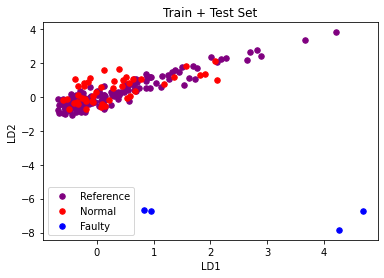

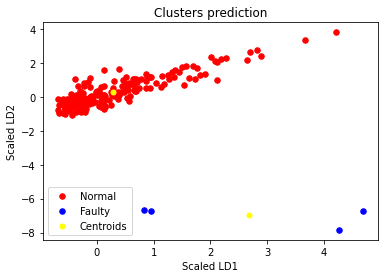

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# import training dataset
datafolder = Path('../Dataset/Data Skripsi 1')
datafile = datafolder/ 'DatasetRz.xlsx'
dataset = pd.read_excel(datafile, header = None, sheet_name='Sheet1')

#Parameters
gamma = 0.00001
refs = 150
buffs = 50
faults = 0 # initial value of faults
acc_threshold_passed = False

xtrain= dataset.iloc[0:refs,:-2]
Ltrain= dataset.iloc[0:refs,-1]

#KFDA = KPCA + LDA
#KPCA
from sklearn.metrics.pairwise import rbf_kernel

K = rbf_kernel(xtrain, gamma = gamma)
K = pd.DataFrame.from_records(K)
#### Centering Kernel Matrix
m = np.shape(xtrain)[0]
seper_m = np.ones((m,m))/m
Kc = K - seper_m.dot(K) - K.dot(seper_m) + seper_m.dot(K).dot(seper_m)
#### KPCA
eigenValues, eigenVectors = np.linalg.eig(Kc)
eigenValues = np.real(eigenValues)
eigenVectors = np.real(eigenVectors)
idx = eigenValues.argsort()[::-1] #Outputs idx for sorting eigenValues and ordering by descending value
eigenValues = eigenValues[idx] #sorting eigenValues by idx
eigenVectors = np.real(eigenVectors[:,idx]) #sorting eigenVectors by idx
#slicing the eigens
eigenValues = eigenValues[:589]
eigenVectors = eigenVectors[:,:589]
kpcamat = []
end_index = 0
for i in range(len(eigenValues)):
    if (eigenValues[i] < 1e-15):
        end_index = i
        #print("index:", i, "value:",eigenValues[i])
        break
    scaled_eigenvector = eigenVectors[:,i]/(np.sqrt(eigenValues[i]))
    kpcamat.append(scaled_eigenvector)
kpcamat = np.array(kpcamat)
#print(np.shape(kpcamat))
kpcamat = kpcamat.T
#### Transforming Kernel Matrix into KPCA-space
xtrainkpca = kpcamat.T.dot(K)
xtrainkpca = pd.DataFrame.from_records(xtrainkpca)
### FDA
classes = np.unique(Ltrain)
k = len(classes)
M = xtrainkpca.mean(axis = 1)
if end_index == 0:
    st = np.diagflat(eigenValues[:]) #Total variance
else:
    st = np.diagflat(eigenValues[:end_index]) #Total variance
#### Looping to find sb
sb=0 #initial value
yt = xtrainkpca.T
yt = pd.DataFrame.from_records(yt)
for j in range(k):
    a = 0
    a = np.where(Ltrain == classes[j])[0]
    Kj = pd.DataFrame()
    an = len(a)
    for ak in range(an):
        ai = a[ak]
        k2add = xtrainkpca.iloc[:,ai]
        Kj[ak] = k2add
    nj = Kj.shape[1]
    Kj = Kj.to_numpy()
    mj = Kj.mean(axis = 1)
    sb = sb + nj*np.outer((mj-M),(mj-M)) #Variance between class

sb = sb/m #Scaling sb
st_i = np.linalg.inv(st)
eigenValues1, eigenVectors1 = np.linalg.eig(st_i.dot(sb))
eigenValues1 = np.real(eigenValues1)
eigenVectors1 = np.real(eigenVectors1)
idx1 = eigenValues1.argsort()[::-1] #Outputs idx for sorting eigenValues and ordering by descending value
eigenValues1 = eigenValues1[idx1] #sorting eigenValues by idx
eigenVectors1 = np.real(eigenVectors1[:,idx1]) #sorting eigenVectors by idx
kfdamat = eigenVectors1[:,:2] / np.sqrt(eigenValues1[:2]) #KFDA Transformation Matrix
#### Transforming KFDA Matrix into KFDA matrix
xtrainkfda = kfdamat.T.dot(xtrainkpca)
xtrainkfda = xtrainkfda.T

from sklearn.preprocessing import RobustScaler
rs = RobustScaler()
xtrainkfda = rs.fit_transform(xtrainkfda)

# Testing Set
while acc_threshold_passed == False:
    print(faults)
    stop_idx = 500-faults
    start_idx = stop_idx-buffs+faults
    x1= dataset.iloc[start_idx:stop_idx,:-2]
    l1= dataset.iloc[start_idx:stop_idx,-1]
    x2= dataset.iloc[530:530+faults,:-2]
    l2= dataset.iloc[530:530+faults,-1]
    xtest = np.concatenate((x1, x2), axis=0)
    Ltest = np.concatenate((l1, l2), axis=0)
    K = rbf_kernel(xtrain, xtest, gamma = gamma)
    xtestkpca = kpcamat.T.dot(K)
    xtestkpca = pd.DataFrame.from_records(xtestkpca)

    xtestkfda = kfdamat.T.dot(xtestkpca)
    xtestkfda = xtestkfda.T
    xtestkfda = rs.transform(xtestkfda)

    c = ['red','blue']
    #Joining Xtrain and Xtest
    Xkfda = np.concatenate((xtrainkfda, xtestkfda), axis=0)
    Ljoin = np.concatenate((Ltrain, Ltest), axis=0)
    for Ls in range(len(Ljoin)):
        if Ljoin[Ls] == 1:
            Ljoin[Ls] = 0
        else:
            Ljoin[Ls] = 1
    sumall = len(Xkfda)

    ## K MEANS
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state = 0)
    y_kmeans = kmeans.fit_predict(Xkfda)
    if sum(y_kmeans[0:refs]) > .5*refs:
        for i in range(len(y_kmeans)):
            if y_kmeans[i] == 1:
                y_kmeans[i] = 0
            elif y_kmeans[i] == 0:
                y_kmeans[i] = 1

    from sklearn.metrics import confusion_matrix
    Lacc = [0 if ls == 1 else 1 for ls in Ltest]    
    cm = confusion_matrix(Lacc,y_kmeans[refs:])
    tp = cm[1][1]
    tn = cm[0][0]
    acc_tp = tp/sum([1 if Laccs == 1 else 0 for Laccs in Lacc])
    acc_tn = tn/sum([1 if Laccs == 0 else 0 for Laccs in Lacc])
    acc = (acc_tp+acc_tn)/2
    if acc >= 0.8:
        print("accuracy threshold reached with faults = ", faults)
        acc_threshold_passed = True
    else:
        faults +=1

#Elbow Method
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 4):
    kmeanswcss = KMeans(n_clusters = i, init = 'k-means++', random_state = 0)
    kmeanswcss.fit(Xkfda)
    wcss.append(kmeanswcss.inertia_)
    
print(acc, wcss)
plt.scatter(xtrainkfda[Ltrain == 1, 0], xtrainkfda[Ltrain == 1, 1], s = 30, c = 'purple', label = 'Reference')
plt.scatter(xtestkfda[Ltest == 1, 0], xtestkfda[Ltest == 1, 1], s = 30, c = 'red', label = 'Normal')
plt.scatter(xtestkfda[Ltest == 2, 0], xtestkfda[Ltest == 2, 1], s = 30, c = 'blue', label = 'Faulty')
plt.title('Train + Test Set')
# plt.xlim([-.1, .1])
# plt.ylim([0, .2])
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend()
plt.show()

plt.scatter(Xkfda[y_kmeans == 0, 0], Xkfda[y_kmeans == 0, 1], s = 30, c = 'red', label = 'Normal')
plt.scatter(Xkfda[y_kmeans == 1, 0], Xkfda[y_kmeans == 1, 1], s = 30, c = 'blue', label = 'Faulty')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 25, c = 'yellow', label = 'Centroids')
plt.title('Clusters prediction')
plt.xlabel('Scaled LD1')
plt.ylabel('Scaled LD2')
plt.legend()
plt.show()